This notebook analyzes the Hartree Fock method for estimating the many-body wave function of fermionic system using density matrices. The topics discussed are from the paper: 

P. Echenique and J. L. Alonso, “A mathematical and computational review of Hartree-Fock SCF methods in Quantum Chemistry,” arXiv preprint arXiv:0705.0337, 2007.

In [2]:
import pyscf
from pyscf import gto, scf
import numpy as np
import matplotlib.pyplot as plt

*************************************************************************************************************************************************************************

The main tool is the Slater determinant; a mean-field approximation for the wavefunction of an ensemble of electrons:  

$$\psi^\text{HF}(r_1, \dots, r_N) =
\frac{1}{\sqrt{N!}}
\begin{vmatrix}
\psi_1(r_1) & \psi_2(r_1) & \cdots & \psi_N(r_1) \\
\psi_1(r_2) & \psi_2(r_2) & \cdots & \psi_N(r_2) \\
\vdots      & \vdots     & \ddots & \vdots      \\
\psi_1(r_N) & \psi_2(r_N) & \cdots & \psi_N(r_N)
\end{vmatrix} \quad \tag{33}$$

where rows = electron coordinate $(r_1, \cdots, r_N$) and columns = spin orbitals ($\psi_1, \cdots, \psi_N$) where each orbital is the solution to the Schrodinger Equation for the corresponding potential well and are assumed to be linearly independent:
$$\langle \psi_i | \psi_j \rangle = \delta_{ij} \quad 1 \leq i,j \leq N \quad \text{and} \quad \langle \psi_i | \psi_i \rangle = 1$$

The Slater determinant is a manifold in $L^2(\mathbb{R}^3) \otimes \mathbb{C}^2 = \mathcal{H}$ where
$$L^2 = \text{square integrable functions over position and} \quad \mathbb{C}^2 \text{  accounts for the 2 different states of angular momentum in a given position, "spin states"}$$

We now define an "Energy" functional on the space of Slater determinants, $$F[\Psi] = \langle \Psi | \hat H | \Psi \rangle \tag{11}$$
In order to minimize this energy, we vary is across the manifold. Since our manifold is non-linear, this can stretch or compress our spin orbitals so that $\langle \psi_i | \psi_i \rangle \neq 0$. To fix this, we identify normal vectors on the manifold with normal vectors in the tangent direction of our manifold using $N^2$ Lagrange multipliers. This yields the Fock operator: $$\tilde F[\Psi] = F[\Psi] + \lambda (\langle \Psi | \Psi \rangle - 1) \tag{13}$$

and an eigenvalue problem between (11) and (13) $$\frac{\delta \tilde F [\Psi]}{\delta \Psi^*} = 0 \iff \hat H \Psi = -\lambda \Psi \quad \text{and} \quad \langle \Psi | \Psi \rangle = 1\tag{14}$$

*******************************************************************************************************************************************************************

Each point on the manifold of Slater determinants corresponds to an N-dimensoniat set of spin orbitals $\{\psi_1, \cdots, \psi_N\}$ and determine a density matrix that projects from $\mathcal{H}$ onto it: $$\rho = \sum_i |\psi_i \rangle \langle \psi_i|$$

Then (11) becomes $$\langle \Psi | \hat H | \Psi \rangle = \sum_i \langle \psi_i | \hat H | \psi_i \rangle = \sum_i Tr(\psi_i^* \hat H \psi_i) = \sum_i Tr(\psi_i \psi_i^* \hat H) = Tr(\sum_i \psi_i \psi_i^* \hat H) = Tr(\rho \hat H)$$

So the energy depends strictly on the subspace spanned by the orbitals. Since $\langle \psi_i | \psi_i \rangle = 1$ is our constraint, we can view solving our eigenvalue problem in (14) as finding a unitary so that it diagonalizes $\tilde F$ so that $$\psi^{(i+1)}(x) = \sum_j U_{kj}\psi_j^{(i)}(x) \tag{58}$$

So to find the density matrix that minimizes our Fock operator, we need a matrix of Lagrange multipliers $\Lambda$, a unitary $U$, and a Fock operator that moves between Slater Determinants.  

******************************************************************************************************************************************************************

This procedure defines a fixed point problem on our non-linear manifold called a self-consistent field (SCF) iteration, using Density matrices:
$$\begin{aligned}
(1) &\quad \text{Initial guess for } \{\psi_i^{(0)}\}_{i=1}^N \\[6pt]
(2) &\quad \text{Build Fock operator } 
F[\rho^0] = h[\rho^0] + J[\rho^0] - K[\rho^0], \text{ a functional of the density } 
\rho^{(0)} = \sum_i |\psi_i^{(0)}\rangle \langle \psi_i^{(0)}| \\[6pt]
(3) &\quad \text{Solve for new configuration } 
\{\psi_i^{(1)}\} \text{ by solving the eigenvalue problem } \\
&\qquad F[\rho^{(0)}]\psi_i(x) = \lambda_i \psi_i(x), 
\text{ where each } \psi_i \text{ corresponds to the lowest } N \text{ eigenvalues} \\[6pt]
(4) &\quad \text{Form new density matrix} \quad \rho^{(1)} = \sum_i |\psi_i^{(1)}\rangle \langle \psi_i^{(1)}|\\[6pt]
(5) &\quad \text{Repeat until } 
\|\rho_i^{(n)} - \rho_i^{(n-1)}\| < \varepsilon
\end{aligned} \tag{pg. 27}$$

Phsyically, this fixed point is interpretted as the potential energy each electron feels being the average of the system with respect to the following Hamiltonian.. 

*************************************************************************************************************************************************************

The total energy each electron experiences being the average energy of the system is called a mean field approximation. To determine this, we add up the energy of each nucleus and electron (h), the repulsion between electrons (J), and the constraint that no two electons can occupy the same space (K): 

$$
E_{\rm GHF} := \langle \Psi | \hat H | \Psi \rangle
=
\underbrace{\sum_i \langle \psi_i | \hat h | \psi_i \rangle}_{h_i}
+
\frac{1}{2} \sum_{i,j} 
\Bigg(
\underbrace{\langle \psi_i \psi_j | \frac{1}{r} | \psi_i \psi_j \rangle}_{J_{ij}}
-
\underbrace{\langle \psi_i \psi_j | \frac{1}{r} | \psi_j \psi_i \rangle}_{K_{ij}}
\Bigg),
\tag{47}
$$

Varying this yields the Fock operator and eigenvalue equation for the general case:

$$
\hat F_{\rm GHF}[\psi] := \hat h
+
\sum_j \hat J_j[\psi] - \hat K_j[\psi],
\tag{52}
$$

$$
\hat F_{\rm GHF}[\psi] \, \psi_i(x) = \sum_j \lambda_{ij} \, \psi_j(x), 
\quad i = 1, \dots, N.
\tag{53}
$$

With respect to the unitary diagonalizing our list of Lagrangians, $$
\psi_k(x) = \sum_j U_{kj} \, \psi'_j(x).
\tag{58}
$$

In this case any orbital can be written as a linear combination of the spin: 

$$\psi(r, \sigma) = \phi^\alpha (r) \alpha(\sigma) + \phi^\beta(r)\beta(\sigma) \tag{35}$$
where $\phi^\alpha$ and $\phi^\beta$ are the spatial components and
$$\begin{bmatrix} \alpha(-\frac{1}{2}) = 0 & \beta(-\frac{1}{2}) = 1 \\ \alpha(\frac{1}{2}) = 1 & \beta(\frac{1}{2}) = 0 \end{bmatrix} \tag{36}$$
so that $\alpha$ and $\beta$ correspond to the orthonormal spin-up and spin-down eigenstates.

*****************************************************************************************************************************************************************
By changing this spin condition, we can obtain the Unrestricted Hartree Fock (UHF) equations and Restricted Hartree Fock (RHF) equations. In UHF, we allow electrons of opposite signs to be pairwise independent, so that a single electron can occupy an orbital by itself. In RHF, we assume electrons are paired, so that each orbital is occupied by a pair of electrons. 

When the radius, r, between orbitals is small, there is maximum overlap between the orbitals. Since paired electrons have lwoer energy, this allows them to pair in the unrestricted case. As $r$ increases, there is less overlap between orbitals so that electrons can decouple and the solution of the SCF iteration becomes larger in the UHF case, giving our bifurcation. For very large $r$, there is no bonding between atoms and RHF=UHF again.

RHF spin: 0
UHF spin: -4.440892098500626e-16
No bifurcation.


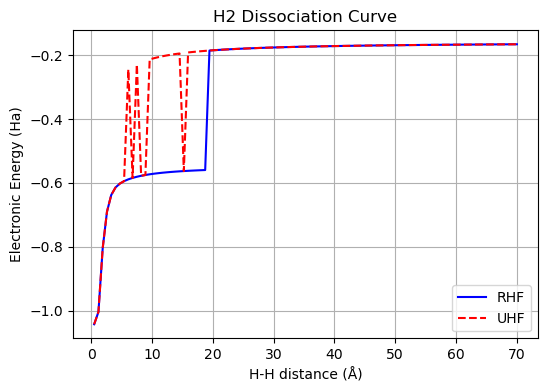

In [4]:
bond_lengths = np.linspace(0.5, 70, 100)
rhf_energies = []
uhf_energies = []
residuals_rhf_list = []
residuals_uhf_list = []

for R in bond_lengths:
    # 4 hydrogen atoms in a line along z-axis
    mol = gto.M(atom=f'H 0 0 0; H 0 0 {R}', basis='sto-3g', spin=0, symmetry=False)

    #mol = gto.M(
    #    atom=f'H 0 0 0; H 0 0 {R}; H 0 0 {2*R}; H 0 0 {3*R}',
    #    basis='sto-3g',
    #    spin=0,      # total spin = 0 for RHF
    #    symmetry=False
    #)
    # RHF calculation
    mf_rhf = scf.RHF(mol)
    mf_rhf.verbose = 0

    # Save RHF Energy
    ehf_rhf = mf_rhf.kernel()
    rhf_energies.append(ehf_rhf)

    # Residuals for RHF
    residuals_rhf = []
    dm = mf_rhf.get_init_guess()
    for _ in range(50):
        ehf_rhf = mf_rhf.kernel(dm0=dm)
        dm_new = mf_rhf.make_rdm1()
        res = np.linalg.norm(dm_new - dm)
        residuals_rhf.append(res)
        dm = dm_new
        if res < 1e-8:
            break
    residuals_rhf_list.append(residuals_rhf)

    # UHF calculation
    mf_uhf = scf.UHF(mol)
    mf_uhf.verbose = 0
    
    # start from perturbed RHF density
    dm_uhf = mf_rhf.make_rdm1() + 0.1*(np.random.rand(*mf_rhf.make_rdm1().shape)-0.5)
    
    # Residuals for UHF
    residuals_uhf = []
    for _ in range(50):
        ehf_uhf = mf_uhf.kernel(dm0=dm_uhf)
        dm_new = mf_uhf.make_rdm1()
        res = np.linalg.norm(dm_new - dm_uhf)
        residuals_uhf.append(res)
        dm_uhf = dm_new
        if res < 1e-8:
            break
    residuals_uhf_list.append(residuals_uhf)

    # Save UHF energy
    ehf_uhf = mf_uhf.kernel(dm0=dm_uhf)
    uhf_energies.append(ehf_uhf)

# Check spins
print("RHF spin:", mf_rhf.spin_square()[0])
print("UHF spin:", mf_uhf.spin_square()[0])

# Find bifurcation
rhf_array = np.array(rhf_energies)
uhf_array = np.array(uhf_energies)
bif_indices = np.where(uhf_array < rhf_array)[0]

if bif_indices.size > 0:
    bif_index = bif_indices[0]
    bif_R = bond_lengths[bif_index]
    print(f"Bifurcation occurs at R = {bif_R} A")
else:
    print("No bifurcation.")

plt.figure(figsize=(6,4))
plt.plot(bond_lengths, rhf_energies, label='RHF', color='blue')
plt.plot(bond_lengths, uhf_energies, label='UHF', color='red', linestyle='--')
plt.xlabel('H-H distance (Å)')
plt.ylabel('Electronic Energy (Ha)')
plt.title('H2 Dissociation Curve')
plt.legend()
plt.grid(True)

plt.savefig('H2_dissociation_curve.png', dpi=300)  # high-res PNG

plt.show()